In [39]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from Utilities.basic_units import radians

from Utilities.operators import make_tree
from Utilities.time_extractor import days_since_distruption
matplotlib.rcParams['figure.dpi'] = 150

In [22]:
folder = 'TDE'
is_tde = True
snap = '196'
m = 5
beta = 2
path = f'{folder}/{snap}'
G = 1
Mbh = 10**m
Rt = Mbh**(1/3)
Rp =  Rt / beta
R0 = 0.6 * Rp

G_SI = 6.6743e-11
Msol = 2e30 #1.98847e30 # kg
Rsol = 7e8 #6.957e8 # m
t = np.sqrt(Rsol**3 / (Msol*G_SI ))

c = 3e8 / (7e8/t)
M_bh = 10**m
Rs = 2*G*Mbh / c**2


Function for orbits

In [23]:
def to_cylindric(x,y):
    radius = np.sqrt(x**2+y**2)
    if x.any() == 0:
        if y.any()>0:
            theta_coord = np.pi/2
        elif y.any() == 0:
            theta_coord = 0
        else:
            theta_coord = 3/2 * np.pi
    else:
        theta_coord = np.arctan2(y,x)
    # theta_coord go from -pi to pi with negative values in the 3rd and 4th quadrant. You want to switch 
    theta_broadcasted = -theta_coord
    return theta_broadcasted, radius

def from_cylindric(theta, r):
    # we need the - in front of theta to be consistent with the function to_cylindric, where we change the orientation of the angle
    theta = -theta
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

def keplerian_orbit(theta, a):
    # we need the - in front of theta to be consistent with the function to_cylindric, where we change the orientation of the angle
    theta = -theta
    p = 2 * a
    radius = p / (1 + np.cos(theta))
    return radius

def orbital_energy(r, v_xy, M = M_bh):
    # no angular momentum??
    energy = G*M/r - v_xy**2/2
    return energy

def tangent_plane(x_data, y_data, dim_data, x_orbit, y_orbit, theta_chosen, radius_chosen):
    # Search where you are in the orbit to then find the previous point
    x_chosen, y_chosen = from_cylindric(theta_chosen, radius_chosen)
    idx_chosen = np.argmin(np.abs(y_chosen - y_orbit)) # orizontal parabola --> unique y values
    if theta_chosen == 0: #i.e. x=Rchosen, which should be pericenter --> draw vertical line
        condition_coord = np.abs(x_data-radius_chosen) < dim_data 
    else:
        m = (y_orbit[idx_chosen] - y_orbit[idx_chosen-1]) / (x_orbit[idx_chosen] - x_orbit[idx_chosen-1])
        ideal_y_value = y_chosen + m * (x_data-x_chosen)
        condition_coord = np.abs(y_data - ideal_y_value) < dim_data
    return condition_coord

def normal_plane(x_data, y_data, dim_data, theta_chosen):
    if np.abs(theta_chosen - np.pi/2) < 0.1: # if theta is close to pi/2
        condition_coord = np.abs(x_data) < dim_data  # vertical line
        condition_coord = np.logical_and(condition_coord, y_data < 0) # only the lower part
    elif np.abs(theta_chosen + np.pi/2) < 0.1: # if theta is close to -pi/2
        condition_coord = np.abs(x_data) < dim_data  # vertical line
        condition_coord = np.logical_and(condition_coord, y_data > 0) # only the upper part
    else:
        # we need the - in front of theta to be consistent with the function to_cylindric, where we change the orientation of the angle
        m = np.tan(-theta_chosen)
        condition_coord = np.abs(y_data - m * x_data) < dim_data
        if np.logical_and(theta_chosen > 0, theta_chosen != np.pi): # if theta is in the third or fourth quadrant
            condition_coord = np.logical_and(condition_coord, y_data < 0)
        elif theta_chosen == 0:
            condition_coord = np.logical_and(condition_coord, x_data >= 0)
        elif np.abs(theta_chosen) == np.pi:
            condition_coord = np.logical_and(condition_coord, x_data < 0)
        else:
            condition_coord = np.logical_and(condition_coord, y_data > 0)
    return condition_coord


In [24]:
# cfr tidal disruption 
xRt = np.linspace(-Rt, Rt, 100)
yRt = np.linspace(-Rt, Rt, 100)
xcfr, ycfr = np.meshgrid(xRt,yRt)
cfr = xcfr**2 + ycfr**2 - Rt**2

# cfr smoothing lenght
xR0 = np.linspace(-R0, R0, 100)
yR0 = np.linspace(-R0, R0, 100)
xcfr0, ycfr0 = np.meshgrid(xR0,yR0)
cfr0 = xcfr0**2 + ycfr0**2 - R0**2


Load data

In [25]:
# sim_tree, X, Y, Z, Vol, VX, VY, VZ, Den, Press, Temp, IE, Diss, Entropy = make_tree(path, snap, is_tde, energy = True)
sim_tree, X, Y, Z, Vol, VX, VY, VZ, Mass, Den, Press, Temp = make_tree(path, snap, is_tde, energy = False)

Star = np.load(f'{path}/Star_{snap}.npy')
# div = np.load(f'{folder}/{snap}/DivV_{snap}.npy')
# shockzone = np.loadtxt(f'data/{snap}/shockzone_{snap}.txt')
# shocksurface = np.loadtxt(f'data/{snap}/shocksurface_{snap}.txt')

R = np.sqrt(X**2 + Y**2 + Z**2)
THETA, RADIUS_cyl = to_cylindric(X, Y)
V = np.sqrt(VX**2 + VY**2 + VZ**2)
Vcyl = np.sqrt(VX**2 + VY**2)
orb_en = orbital_energy(RADIUS_cyl, Vcyl)
dim_cell = Vol**(1/3) # according to Elad
time, tfb = days_since_distruption(f'{path}/snap_{snap}_grad.h5', m=m, choose = 'tfb')

# Shock zone
# idx_zone = shockzone[0]
# idx_zone = np.array([int(i) for i in idx_zone])
# x_zone = X[idx_zone]
# y_zone = Y[idx_zone]
# z_zone = Z[idx_zone]
# Vx_zone = VX[idx_zone]
# Vy_zone = VY[idx_zone]
# Vz_zone = VZ[idx_zone]
# Diss_zone = Diss[idx_zone]
# dim_cell_zone = dim_cell[idx_zone]
# div_zone = div[idx_zone]

# Shock surface
# idx_surf = shocksurface[0]
# idx_surf = np.array([int(i) for i in idx_surf])
# x_surf = x_zone[idx_surf]
# y_surf = y_zone[idx_surf]
# z_surf = z_zone[idx_surf]
# Vx_surf = Vx_zone[idx_surf]
# Vy_surf = Vy_zone[idx_surf]
# dim_cell_surf = dim_cell_zone[idx_surf]
# div_surf = div_zone[idx_surf]


days after disruption: 2.7332186695503924, t_fall: 12.649110640673518


Midplane 

In [26]:
# take wanted data
midplane = np.abs(Z) < dim_cell
# midplane_zone = np.abs(z_zone)< dim_cell_zone
# midplane_surf = np.abs(z_surf)<dim_cell_surf

X_midplane = X[midplane]
Y_midplane = Y[midplane]
VX_midplane = VX[midplane]
VY_midplane = VY[midplane]
Vol_midplane = Vol[midplane]
dim_midplane = dim_cell[midplane]
Temp_midplane = Temp[midplane]
Den_midplane = Den[midplane]
# Diss_midplane = Diss[midplane]
# Entropy_midplane = Entropy[midplane]
Star_midplane = Star[midplane]
orb_en_midplane = orb_en[midplane]
# div_midplane = div[midplane]

# zone_midplane_x = x_zone[midplane_zone]
# zone_midplane_y = y_zone[midplane_zone]

# x_midplane_surf = x_surf[midplane_surf]
# y_midplane_surf = y_surf[midplane_surf]
# Vx_midplane_surf = Vx_surf[midplane_surf]
# Vy_midplane_surf = Vy_surf[midplane_surf]
# div_midplane_surf = div_surf[midplane_surf]

Text(0.5, 1.0, 'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = 0.216')

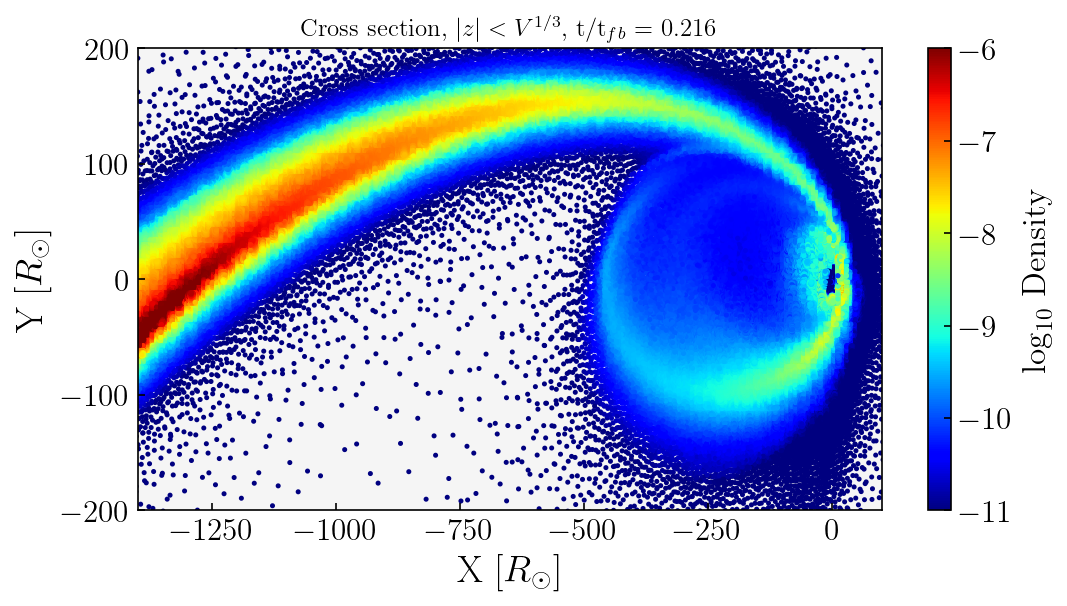

In [27]:
# Keplerian orbit
fig, ax = plt.subplots(1,1, figsize = (8,4))
img = ax.scatter(X_midplane, Y_midplane, c = np.log10(Den_midplane), s = 2, cmap = 'jet', vmin = -11, vmax = -6)
cbar = plt.colorbar(img)
cbar.set_label(r'$\log_{10}$ Density', fontsize = 16)
ax.set_xlim(-1400,100)
ax.set_ylim(-200,200)
ax.set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax.set_ylabel(r'Y [$R_\odot$]', fontsize = 18)
plt.title(r'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = ' + str(np.round(tfb,3)))


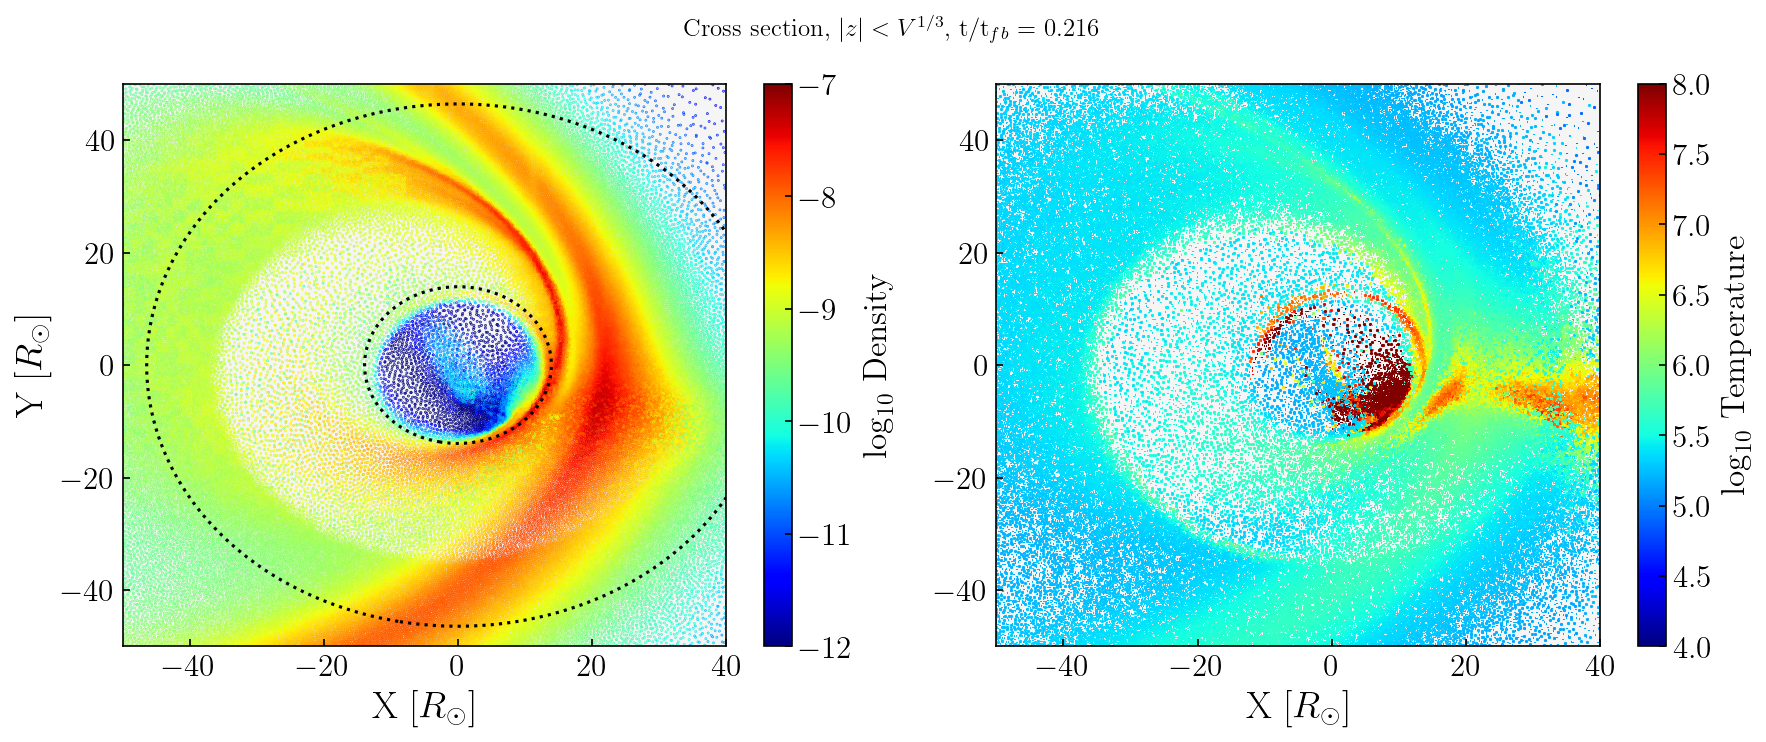

In [29]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
img = ax[0].scatter(X_midplane, Y_midplane, c = np.log10(Den_midplane), s = 0.1, cmap = 'jet', vmin = -12, vmax = -7)
ax[0].contour(xcfr, ycfr, cfr, [0], linestyles = 'dotted', colors = 'k')
ax[0].contour(xcfr0, ycfr0, cfr0, [0], linestyles = 'dotted', colors = 'k')
cbar = plt.colorbar(img)#, format='%.0e')
cbar.set_label(r'$\log_{10}$ Density', fontsize = 16)
ax[0].set_xlim(-50,40)
ax[0].set_ylim(-50,50)
ax[0].set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax[0].set_ylabel(r'Y [$R_\odot$]', fontsize = 18)

img1 = ax[1].scatter(X_midplane, Y_midplane, c = np.log10(Temp_midplane), marker= 's', s = 0.1, cmap = 'jet', vmin = 4, vmax = 8)
cbar1 = plt.colorbar(img1)#, format='%.0e')
cbar1.set_label(r'$\log_{10}$ Temperature', fontsize = 16)
ax[1].set_xlim(-50,40)
ax[1].set_ylim(-50, 50)
ax[1].set_xlabel(r'X [$R_\odot$]', fontsize = 18)
plt.suptitle(r'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = ' + str(np.round(tfb,3)))

plt.tight_layout()

In [30]:
orben_mid_log10nan = np.nan_to_num(np.log10(orb_en_midplane))

/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_45745/2311946758.py:1: RuntimeWarning: invalid value encountered in log10
  orben_mid_log10nan = np.nan_to_num(np.log10(orb_en_midplane))


Text(0.5, 1.0, 'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = 0.216')

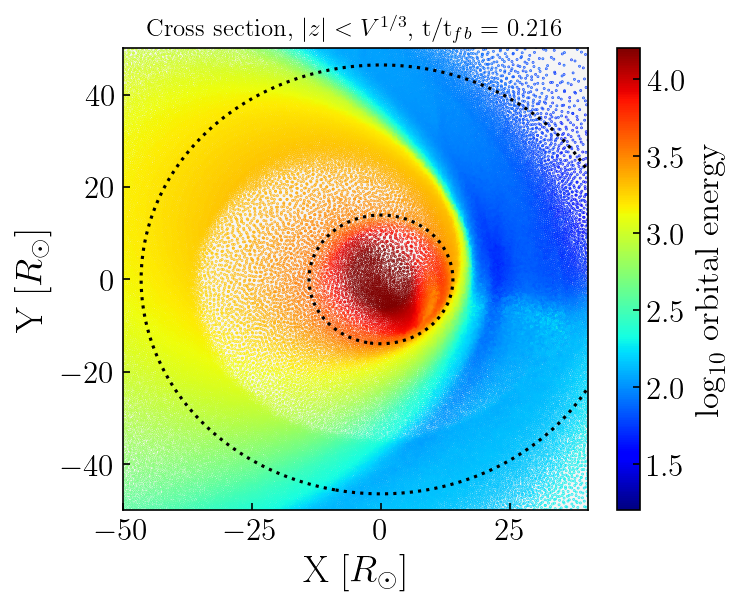

In [31]:
fig, ax = plt.subplots(figsize = (5,4))
img = ax.scatter(X_midplane, Y_midplane, c = orben_mid_log10nan, s = 0.1, cmap = 'jet', vmin = 1.2, vmax = 4.2)
ax.contour(xcfr, ycfr, cfr, [0], linestyles = 'dotted', colors = 'k')
ax.contour(xcfr0, ycfr0, cfr0, [0], linestyles = 'dotted', colors = 'k')
cbar = plt.colorbar(img)#, format='%.0e')
cbar.set_label(r'$\log_{10}$ orbital energy', fontsize = 16)
ax.set_xlim(-50,40)
ax.set_ylim(-50,50)
ax.set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax.set_ylabel(r'Y [$R_\odot$]', fontsize = 18)
plt.title(r'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = ' + str(np.round(tfb,3)))

Text(0.5, 1.0, 'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = 0.216')

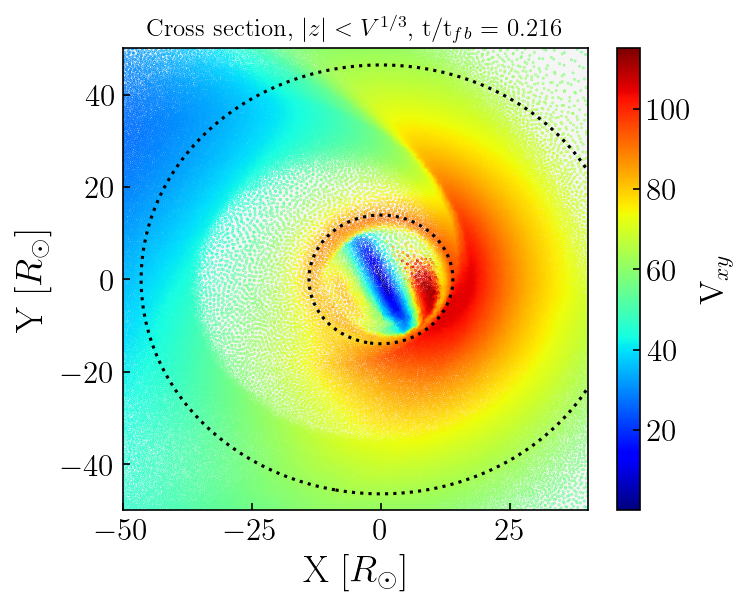

In [32]:
fig, ax = plt.subplots(figsize = (5,4))
img = ax.scatter(X_midplane, Y_midplane, c = Vcyl[midplane], s = 0.1, cmap = 'jet')#, vmin = 1.2, vmax = 4.2)
ax.contour(xcfr, ycfr, cfr, [0], linestyles = 'dotted', colors = 'k')
ax.contour(xcfr0, ycfr0, cfr0, [0], linestyles = 'dotted', colors = 'k')
cbar = plt.colorbar(img)#, format='%.0e')
cbar.set_label(r'V$_{xy}$', fontsize = 16)
ax.set_xlim(-50,40)
ax.set_ylim(-50,50)
ax.set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax.set_ylabel(r'Y [$R_\odot$]', fontsize = 18)
plt.title(r'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = ' + str(np.round(tfb,3)))

X-Z plane

In [33]:
ychosen = Rp
crossXZ = np.abs(Y-ychosen) < dim_cell

X_crossXZ = X[crossXZ]
Z_crossXZ = Z[crossXZ]
VX_crossXZ = VX[crossXZ]
VZ_crossXZ = VZ[crossXZ]
Temp_crossXZ = Temp[crossXZ]
Den_crossXZ = Den[crossXZ]

Text(0.5, 1.0, 'Cross section, Y = $R_{p}$')

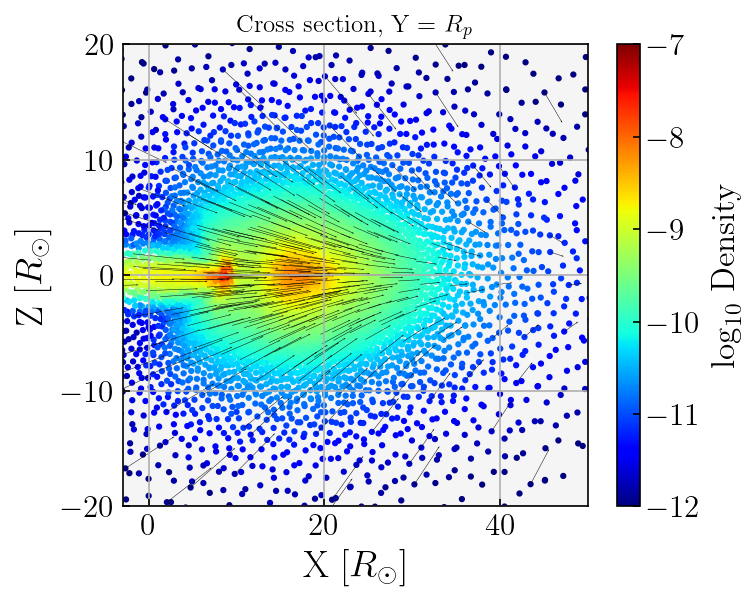

In [34]:
fig, ax = plt.subplots(1,1, figsize = (5,4))
img = ax.scatter(X_crossXZ, Z_crossXZ, c = np.log10(Den_crossXZ),  s = 4, cmap = 'jet', vmin = -12, vmax = -7)
ax.quiver(X_crossXZ[::20], Z_crossXZ[::20], VX_crossXZ[::20], VZ_crossXZ[::20], color = 'k', angles='xy', scale_units='xy', width = 1e-3, scale = 10)
cbar = plt.colorbar(img)
cbar.set_label(r'$\log_{10}$ Density', fontsize = 16)
ax.set_xlim(-3,50)
ax.set_ylim(-20,20)
ax.set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax.set_ylabel(r'Z [$R_\odot$]', fontsize = 18)
plt.grid()
plt.title(r'Cross section, Y = $R_{p}$')

In [35]:
theta_lim = 3/4 * np.pi
# orbit goes from -np.pi to np.pi 
theta_arr = np.arange(-theta_lim, theta_lim, 0.02) 

# keplerian orbit 
orbit = keplerian_orbit(theta_arr, a = Rp)
x_orbit, y_orbit = from_cylindric(theta_arr, orbit) 

In [36]:
theta_chosen = np.pi/4
radius_chosen = keplerian_orbit(theta_chosen, a = Rp)
x_chosen, y_chosen = from_cylindric(theta_chosen, radius_chosen)

condition_tg = tangent_plane(X, Y, dim_cell, x_orbit, y_orbit, theta_chosen, radius_chosen)
X_tg = X[condition_tg]
Y_tg = Y[condition_tg]
Z_tg = Z[condition_tg]
Den_tg = Den[condition_tg]
theta_tg = THETA[condition_tg]
X_tg_midplane = X_tg[np.abs(Z_tg) < dim_cell[condition_tg]]
Y_tg_midplane = Y_tg[np.abs(Z_tg) < dim_cell[condition_tg]]

condition_norm = normal_plane(X, Y, dim_cell, theta_chosen)
X_norm = X[condition_norm]
Y_norm = Y[condition_norm]
Z_norm = Z[condition_norm]
Den_norm = Den[condition_norm]
RADIUS_cyl_norm = RADIUS_cyl[condition_norm]
X_norm_midplane = X_norm[np.abs(Z_norm) < dim_cell[condition_norm]]
Y_norm_midplane = Y_norm[np.abs(Z_norm) < dim_cell[condition_norm]]

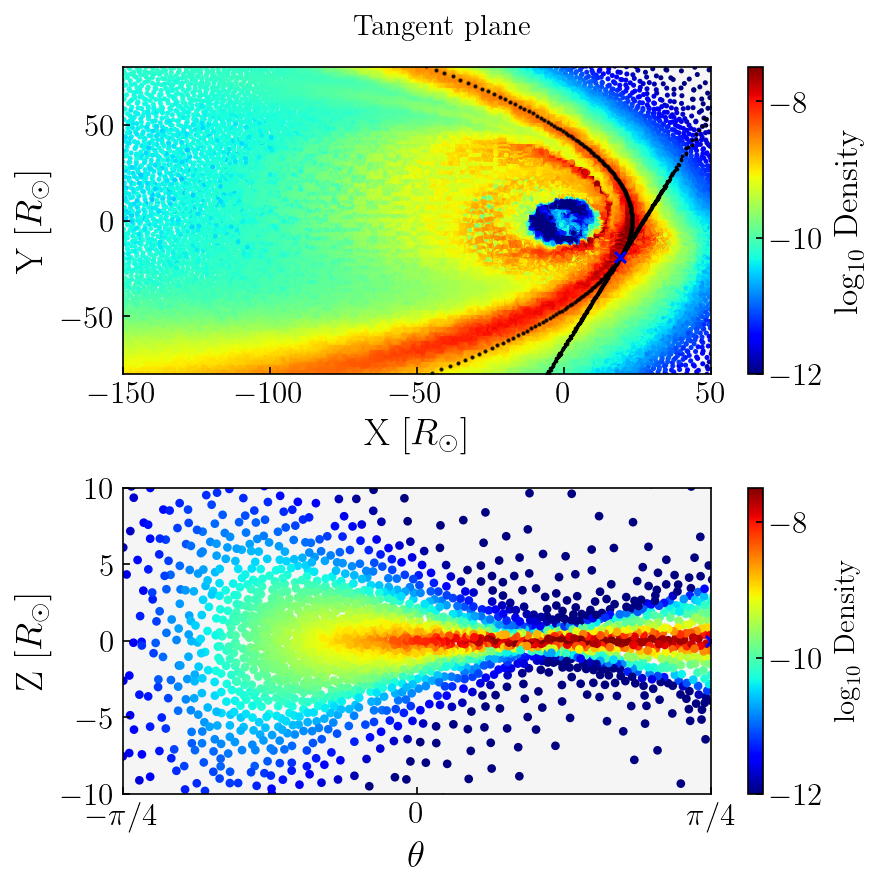

In [44]:
fig, ax = plt.subplots(2,1, figsize = (8,8))
img = ax[0].scatter(X_midplane, Y_midplane, c = np.log10(Den_midplane), s = 2, cmap = 'jet', vmin = -12, vmax = -7.5)
cbar = plt.colorbar(img)
cbar.set_label(r'$\log_{10}$ Density', fontsize = 16)
ax[0].scatter(X_tg_midplane, Y_tg_midplane, s = 0.5, c = 'k')
ax[0].scatter(x_orbit, y_orbit, color = 'k', s = 1, alpha = 0.8)
ax[0].scatter(x_chosen, y_chosen, marker = 'x', s = 27, c = 'b')
ax[0].set_xlim(-150,50)
ax[0].set_ylim(-80,80)
ax[0].set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax[0].set_ylabel(r'Y [$R_\odot$]', fontsize = 18)

img1 = ax[1].scatter(theta_tg * radians, Z_tg, xunits=radians, c = np.log10(Den_tg),  cmap = 'jet', s = 10, vmin = -12, vmax = -7.5)
cbar1 = plt.colorbar(img1)#, format='%.0e')
cbar1.set_label(r'$\log_{10}$ Density', fontsize = 14)
ax[1].scatter(theta_chosen, 0, marker = 'x', s = 27, c = 'b')
ax[1].set_xlim(- np.pi/4, np.pi/4)
ax[1].set_ylim(-10,10)
ax[1].set_xlabel(r'$\theta$', fontsize = 18)
ax[1].set_ylabel(r'Z [$R_\odot$]', fontsize = 18)

plt.suptitle('Tangent plane', fontsize = 14)
plt.tight_layout()

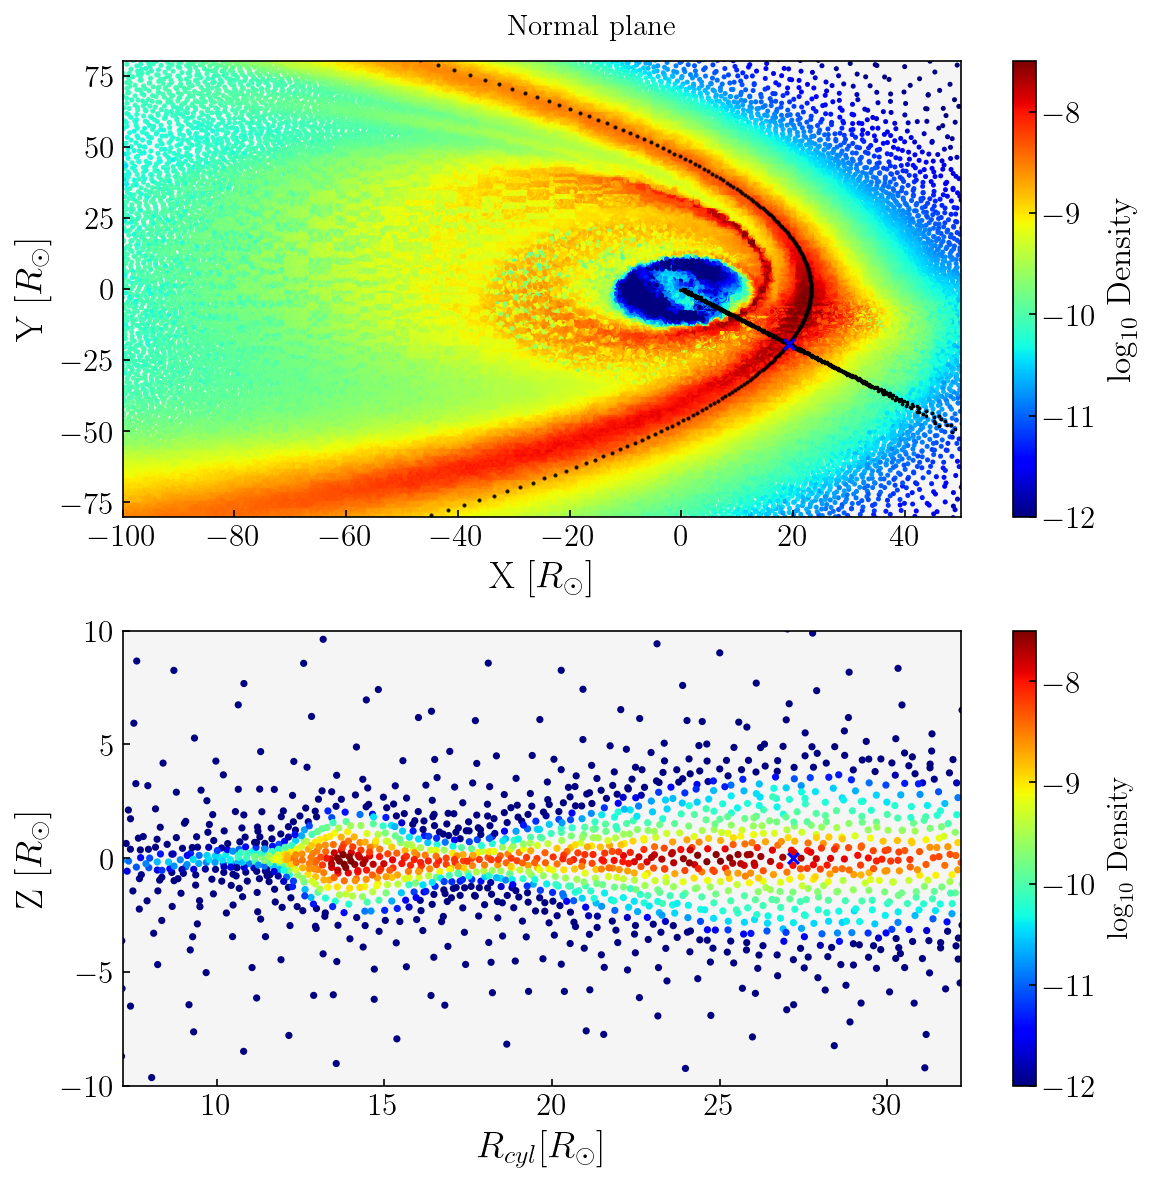

In [43]:
fig, ax = plt.subplots(2,1, figsize = (8,8))
img = ax[0].scatter(X_midplane, Y_midplane, c = np.log10(Den_midplane), s = 2, cmap = 'jet', vmin = -12, vmax = -7.5)
cbar = plt.colorbar(img)
cbar.set_label(r'$\log_{10}$ Density', fontsize = 16)
ax[0].scatter(X_norm_midplane, Y_norm_midplane, s = 0.5, c = 'k')
ax[0].scatter(x_orbit, y_orbit, color = 'k', s = 1, alpha = 0.8)
ax[0].scatter(x_chosen, y_chosen, marker = 'x', s = 27, c = 'b')
ax[0].set_xlim(-100,50)
ax[0].set_ylim(-80,80)
ax[0].set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax[0].set_ylabel(r'Y [$R_\odot$]', fontsize = 18)

img1 = ax[1].scatter(RADIUS_cyl_norm, Z_norm, c = np.log10(Den_norm),  cmap = 'jet', s = 6, vmin = -12, vmax = -7.5)
cbar1 = plt.colorbar(img1)#, format='%.0e')
cbar1.set_label(r'$\log_{10}$ Density', fontsize = 14)
ax[1].scatter(radius_chosen, 0, marker = 'x', s = 27, c = 'b')
ax[1].set_xlim(radius_chosen - 20, radius_chosen + 5)
ax[1].set_ylim(-10,10)
ax[1].set_xlabel(r'$R_{cyl} [R_\odot]$', fontsize = 18)
ax[1].set_ylabel(r'Z [$R_\odot$]', fontsize = 18)

plt.suptitle('Normal plane', fontsize = 14)
plt.tight_layout()

In [42]:
# fig, ax = plt.subplots(1,1, figsize = (6,4))
# img = ax.scatter(X_midplane, Y_midplane, c = Diss_midplane/Vol_midplane, s = 5, cmap = 'jet', vmin = -1e-6, vmax = 1e-6)
# cbar = plt.colorbar(img)#, format='%.0e')
# cbar.set_label('energy density dissipation', fontsize = 16)
# ax.plot(zone_cross_x, zone_cross_y, 'ks', markerfacecolor='none', ms = 5, markeredgecolor='k', label = 'shock zone')
# #ax.plot(x_cross_surf, y_cross_surf, 'ks', markerfacecolor='none', ms = 5, markeredgecolor='k', label = 'shock surface')
# ax.set_xlim(3,29)
# ax.set_ylim(-18,23)
# ax.set_xlabel(r'X [$R_\odot$]', fontsize = 18)
# ax.set_ylabel(r'Y [$R_\odot$]', fontsize = 18)
# plt.grid()
# plt.title(r'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = ' + str(np.round(tfb,3)))
# plt.legend(loc = 'upper right')
# #plt.savefig('Figs/EnDisszone.png')